In [2]:
%matplotlib inline

import numpy as np
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO

import seaborn as sns
import matplotlib.pyplot as plt

import glob

import subprocess
from subprocess import call

import re

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas

import pickle

from scipy import stats

import random

from scipy.stats import fisher_exact

In [3]:
def prepare_data_for_trips2(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, linew=9):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    
    return d


def trips_full2(d, name='test.png', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew']
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
        
        
        
    red.set_facecolor('coral')
    green.set_facecolor('mediumseagreen')
    blue.set_facecolor('cornflowerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS
    #if cds is True:
        #rect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)

    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            orfs.add_patch(rect)
        
            orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)

    
    
def prepare_data_for_trips2(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, name='test.png', linew=9):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    
    return d


def trips_full2(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1.5,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
        
        
        
    red.set_facecolor('coral')
    green.set_facecolor('mediumseagreen')
    blue.set_facecolor('cornflowerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS
    #if cds is True:
        #rect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)

    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            orfs.add_patch(rect)
        
            orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    plt.savefig(name+'.png', dpi = 300, bbox_inches = 'tight')
    

# Metadata, RiboSET, PhyloSET

In [4]:
metadata_pc_g25 = pd.read_csv('../../tmp_res/metadata_pc_g25.txt', sep='\t')
meta = pd.read_csv('../../tmp_res/local_and_global_df_g25ovlp_g35ovlp_g38ovlp_refseqovlp_strand_FRAMES_PhyloCSF.txt', sep='\t')

In [5]:
# open SET1 (PhyloSET) and SET2 (RiboSET)
PhyloSET = pd.read_csv('../../tmp_res/SET1.txt', sep='\t')



RiboSET = pd.read_csv('../../tmp_res/SET2.txt', sep='\t')

RiboSET['tr_id1'] = [x.split('.')[0] for x in RiboSET['tr_id'].tolist()]

RiboSET = RiboSET[(~RiboSET['Riboseq_Summary'].str.contains('ATG')) & 
                  (~RiboSET['tr_id'].str.contains('PAR'))]

print (RiboSET.shape[0])

390


In [6]:
RiboSET_CDS_cov_df = pd.read_csv('../tmp_res/RiboSET_392_df_coverages.txt', sep='\t')
RiboSET_CDS_cov_df.columns = ['tr_id1', 'Z_score', 'CDS_coverage', 'NTE_coverage',
       'CDS_nonzero_fraction', 'NTE_nonzero_fraction']
RiboSET_CDS_cov_df = RiboSET_CDS_cov_df[RiboSET_CDS_cov_df['tr_id1'].isin(RiboSET['tr_id1'].tolist())]

RiboSET_CDS_cov_df[0:2]

,tr_id1,Z_score,CDS_coverage,NTE_coverage,CDS_nonzero_fraction,NTE_nonzero_fraction
0,ENST00000379389,-0.731864,284.150602,31.120000,0.333333,0.178808
1,ENST00000349431,-0.508594,102.473077,46.859375,0.332051,0.250000


## RiboSET_ext 

In [7]:
transl_with_all_codons = pd.read_csv('../../data/extensions_TripsViz_1perGene_AUG_NearCognates.txt', sep=',')
transl_with_all_codons.columns = ['gene_ext', 'tr_id1', 'Start_ext', 'Stop_ext', 'len_ext', 
                                 'global_rank_ext', 'type_all_codons', 'trips_viz_link', 'Start_codon_ext', 
                                 'Highframe rank', 'Highframe value',
       'Lowframe rank', 'Lowframe value', 'Stop rank', 'Stop value',
       'Start rank', 'Start value', 'Coverage rank', 'Coverage_value_ext',
       'Amino acid sequence', 'Proteomics_count_ext', 'CDS_ratio']
transl_with_all_codons2 = transl_with_all_codons[['gene_ext', 'tr_id1', 'Start_ext', 'Stop_ext', 
                                                 'global_rank_ext', 'Start_codon_ext', 
                                                 'Proteomics_count_ext', 'Coverage_value_ext', 'CDS_ratio']]
transl_with_all_codons2['Riboseq_Summary'] = transl_with_all_codons2['Start_codon_ext']+'; '+transl_with_all_codons2['Start_ext'].astype(str)+'-'+transl_with_all_codons2['Stop_ext'].astype(str)+'; Rank: '+transl_with_all_codons2['global_rank_ext'].astype(str)+'; cov: '+np.round(transl_with_all_codons2['Coverage_value_ext'],2).astype(str)

top5000 = transl_with_all_codons2[0:5000]

top5000_meta = top5000.merge(meta, on='tr_id1', how='inner')

top5000_meta['len_codons'] = (top5000_meta['Stop_ext'] - top5000_meta['Start_ext']) // 3

# theoretical extensions should be no less than 20 codons (works for initiatial filter and for PhyloSET)
# but in practice it could be shorter
# let's say 10aa

# select 0 ovlps and where theoretical extension is at least 20 codons  
RiboSET_EXT = top5000_meta[(top5000_meta['ovlp'] == '0;0;0') & 
                                  (top5000_meta['Start_codon_ext'] != 'ATG') & 
                                  (top5000_meta['tr_id1'].isin(meta[meta['len_codons'] >= 20]['tr_id1'].tolist()))]

print (RiboSET_EXT.shape[0])

# ~4k RiboSET ext with non-zero CDS cov in my data 
RiboSET_EXT_cds_cov_nonzero = pd.read_csv('../tmp_res/RiboSET_EXT_cds_cov_nonzero_theor_len_20codons_3663genes.txt', sep='\t')
RiboSET_EXT_cds_cov_nonzero = RiboSET_EXT_cds_cov_nonzero.merge(RiboSET_EXT, on='tr_id1', how='inner')
RiboSET_EXT_cds_cov_nonzero = RiboSET_EXT_cds_cov_nonzero[RiboSET_EXT_cds_cov_nonzero['NTE_coverage'] > 0]
RiboSET_EXT_cds_cov_nonzero = RiboSET_EXT_cds_cov_nonzero[~RiboSET_EXT_cds_cov_nonzero['tr_id'].str.contains('PAR')]
RiboSET_EXT_cds_cov_nonzero.to_csv('../tmp_res/FINAL_RiboSET_EXT_cds_cov_nonzero_theor_len_20codons_3532genes.txt', 
                                  sep='\t', index=False)

print (RiboSET_EXT_cds_cov_nonzero.shape[0])

RiboSET_EXT_cds_cov_nonzero = RiboSET_EXT_cds_cov_nonzero[RiboSET_EXT_cds_cov_nonzero['CDS_coverage'] > 0.06]

RiboSET_EXT_cds_cov_nonzero.to_csv('FINAL_RiboSET_EXT_cds_cov_nonzero_theor_len_20codons_3532genes.txt', 
                                  sep='\t', index=False)

print ('final shape of RiboSET_EXT', RiboSET_EXT_cds_cov_nonzero.shape[0], 'min CDS cov:', RiboSET_EXT_cds_cov_nonzero['CDS_coverage'].min())

print (len(set(RiboSET_EXT_cds_cov_nonzero['gene'].tolist()).intersection(RiboSET['gene'].tolist())))

/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


3722
3530
final shape of RiboSET_EXT 3451 min CDS cov: 0.060654429369513166
390


## Check that theor ext do no have any in-frame AUGs to exclude that in some cases initiation can happen from them? 

# Genes that are not in trips-viz pred set 

In [8]:
match = pd.read_csv('../tmp_res/25079_19codons_UPD_trs_coverages.txt', sep='\t')


match['NTE_nonzero_fraction'] = match['NTE_nonzero_fraction']*3
match['CDS_nonzero_fraction'] = match['CDS_nonzero_fraction']*3


subset = match[(match['NTE_nonzero_fraction'] < 0.0005) & 
               (match['NTE_coverage'] < 0.005) & 
               (match['CDS_coverage'] > 1) & 
               (match['CDS_nonzero_fraction'] > 0.3)].sort_values(by='CDS_coverage', ascending=False)


subset.columns = ['tr_id1', 'Z_score', 'CDS_coverage', 'NTE_coverage',
       'CDS_nonzero_fraction', 'NTE_nonzero_fraction']

# one gene one transcript
subset = subset.merge(meta[~meta['tr_id'].str.contains('PAR')][['tr_id1', 'gene', 'ovlp']], on='tr_id1', how='inner')#.drop_duplicates('gene')


subset = subset[subset['ovlp'] == '0;0;0']
print (subset.shape[0])

# no genes in RiboSET and 
subset = subset[~subset['gene'].isin(RiboSET['gene'].tolist())]
subset = subset[~subset['gene'].isin(RiboSET_EXT_cds_cov_nonzero['gene_ext'].tolist())]
subset = subset[~subset['gene'].isin(['C14orf178', 'C16orf71', 'C16orf89', 'C19orf38', 
                                      'C21orf2', 'C22orf15', 'C2orf50', 'C7orf26', 'C2orf40', 'C8orf46'])]

#print (subset.tr_id1.nunique(), subset.gene.nunique())

# one gene per transcript with max CDS score
subset = subset[subset.groupby(['gene'])['CDS_coverage'].transform(max) == subset['CDS_coverage']].sort_values(by='CDS_coverage').drop_duplicates('gene')

print (subset['gene'].nunique(), subset['tr_id1'].nunique())

subset[6:12]

607
384 384


,tr_id1,Z_score,CDS_coverage,NTE_coverage,CDS_nonzero_fraction,NTE_nonzero_fraction,gene,ovlp
738,ENST00000427495,-0.343449,1.080000,0.0,0.370526,0.0,PLD5,0;0;0
733,ENST00000391709,-0.448547,1.104457,0.0,0.371866,0.0,ZNF470,0;0;0
725,ENST00000410004,-0.492276,1.119816,0.0,0.410138,0.0,TMEM139,0;0;0
724,ENST00000559785,-0.355203,1.122010,0.0,0.351675,0.0,PSTPIP1,0;0;0
723,ENST00000355014,-0.448979,1.135171,0.0,0.384514,0.0,SEMA4A,0;0;0
721,ENST00000436027,-0.259597,1.136000,0.0,0.408000,0.0,YJEFN3,0;0;0


In [9]:
CDS_cov = 1.160804
CDS_non_zero_fraction = 0.36
NTE_coverage = 0

In [10]:
subset[['tr_id1', 'gene', 'CDS_coverage', 'NTE_coverage', 'CDS_nonzero_fraction', 'NTE_nonzero_fraction', 'ovlp']].to_csv('UntranslSET_384genes.txt', sep='\t', index=False)

# Plot some candidates

PCMTD1 ENST00000544451
---
133
0


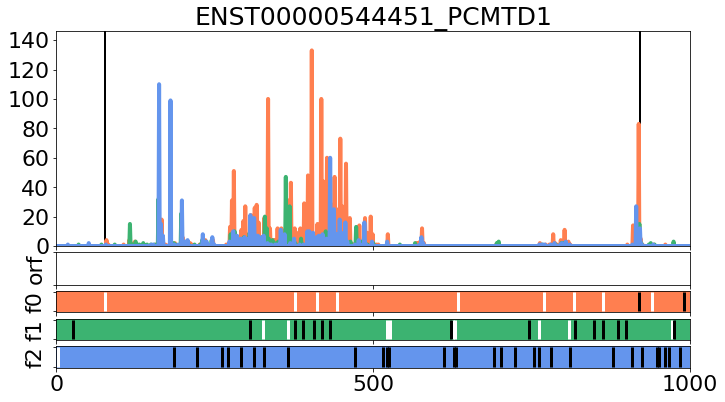

In [11]:
tr_id = 'ENST00000544451'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=[0, 1000],
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

MGAT4C ENST00000548651
---
33
0


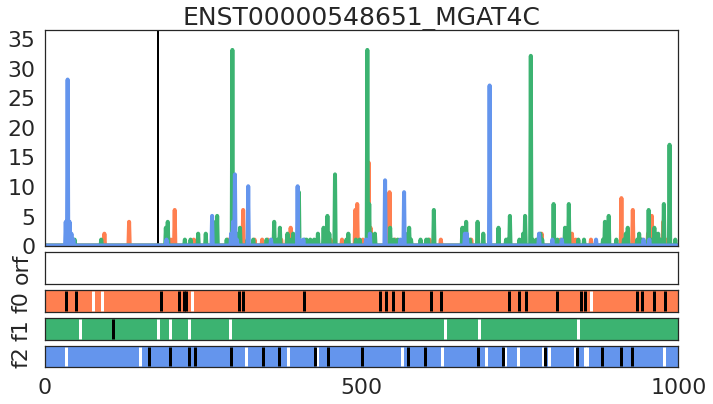

In [123]:
tr_id = 'ENST00000548651'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=[0, 1000],
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

FANK1 ENST00000368689
---
11
0


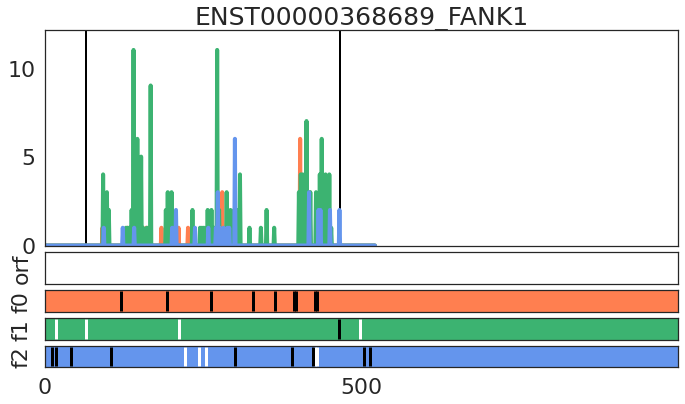

In [124]:
tr_id = 'ENST00000368689'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=[0, 1000],
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

SIRPG ENST00000381580
---
17
0


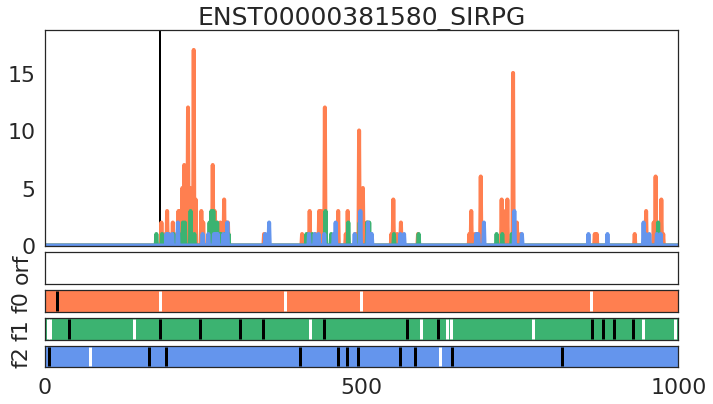

In [125]:
tr_id = 'ENST00000381580'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=[0, 1000],
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

TMEFF2 ENST00000392314
---
27
0


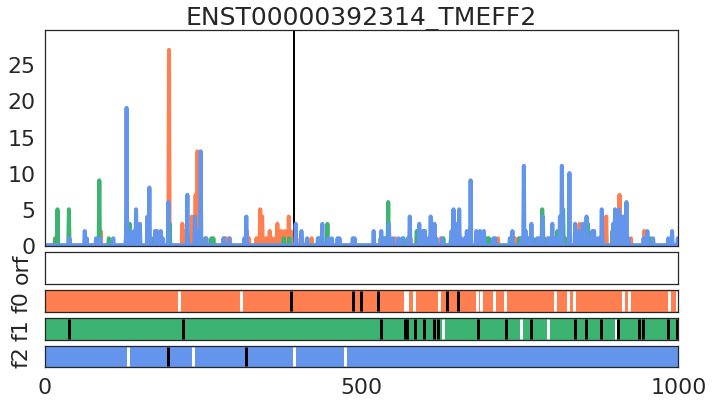

In [126]:
tr_id = 'ENST00000392314'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=[0, 1000],
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

STAT4 ENST00000358470
---
14
0


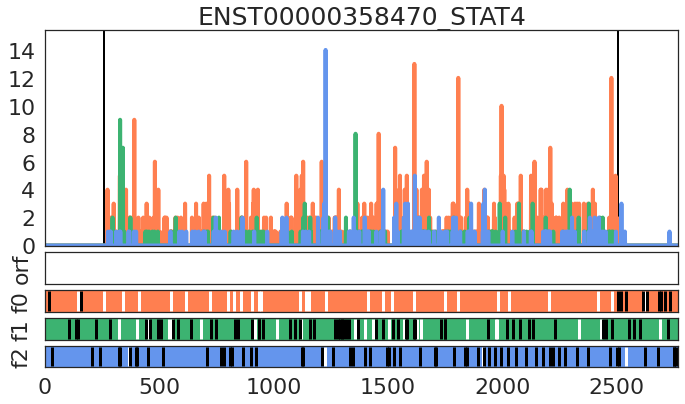

In [127]:
tr_id = 'ENST00000358470'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =2, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims='full',
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

PCDH20 ENST00000409204
---
17
0


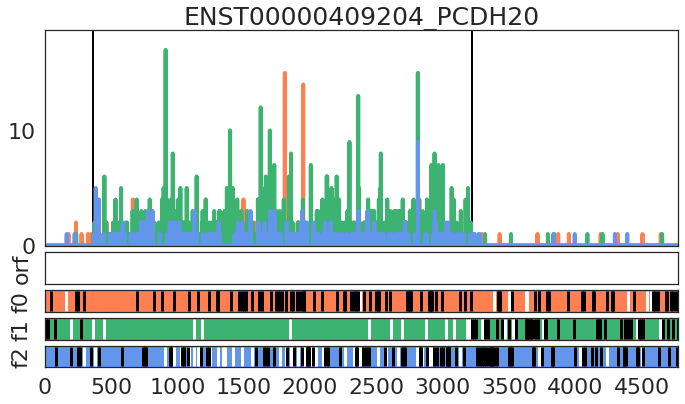

In [128]:
tr_id = 'ENST00000409204'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims='full',
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

SEZ6 ENST00000360295
---
31
0


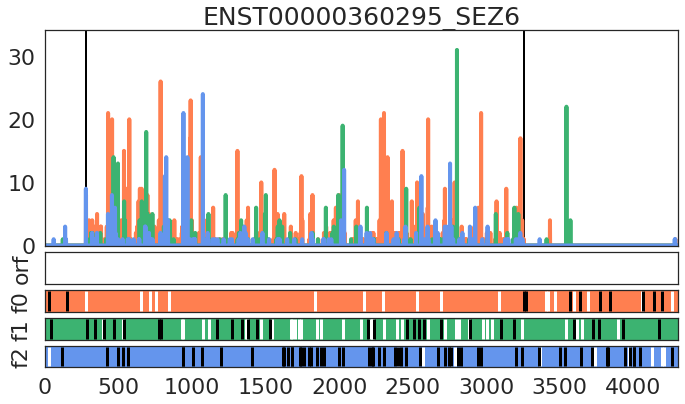

In [129]:
tr_id = 'ENST00000360295'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims='full',
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

EPHA8 ENST00000374644
---
32
0


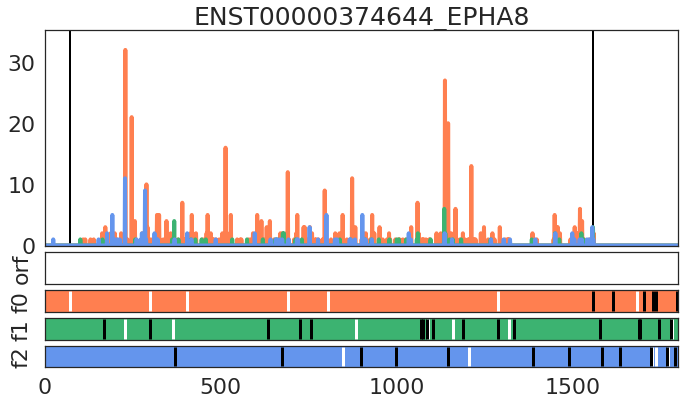

In [130]:
tr_id = 'ENST00000374644'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims='full',
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

FAM92A1 ENST00000359421
---
710
0


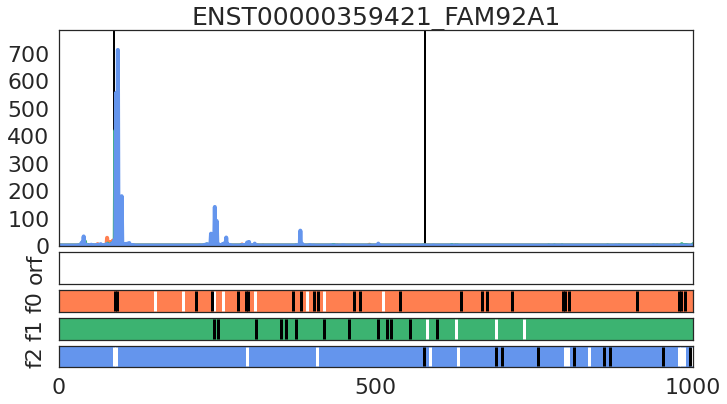

In [131]:
tr_id = 'ENST00000359421'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=[0, 1000],
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

FAM91A1 ENST00000521166
---
645
0


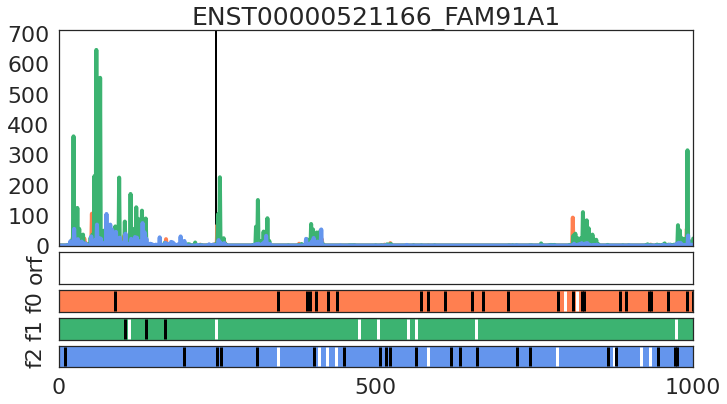

In [132]:
tr_id = 'ENST00000521166'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=[0, 1000],
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

CLIC5 ENST00000339561
---
20
0


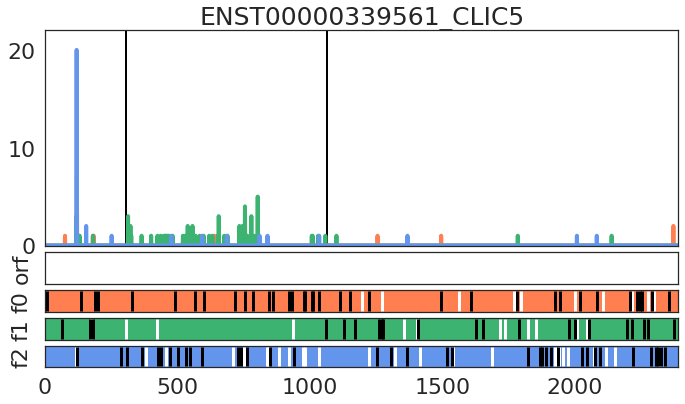

In [133]:
tr_id = 'ENST00000339561'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

SCAMP4 ENST00000414057
---
608
0


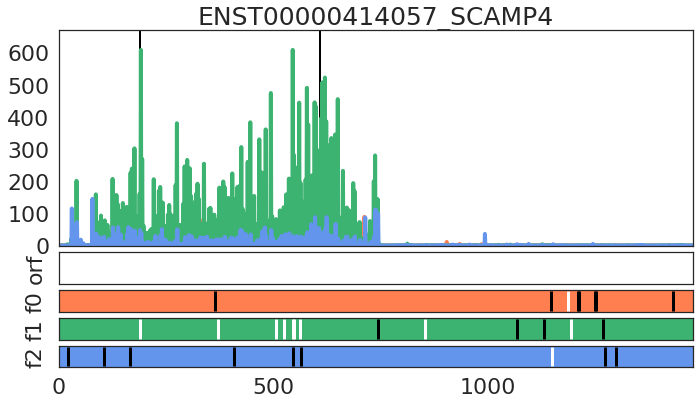

In [134]:
tr_id = 'ENST00000414057'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

SPAG6 ENST00000313311
---
9
0


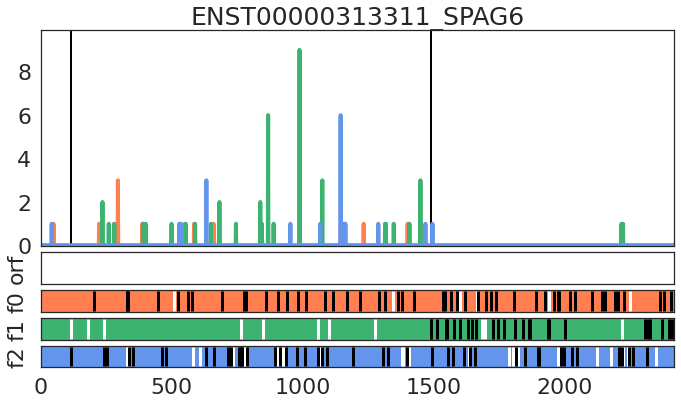

In [135]:
tr_id = 'ENST00000313311'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =2, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

ADCY4 ENST00000557056
---
9
0


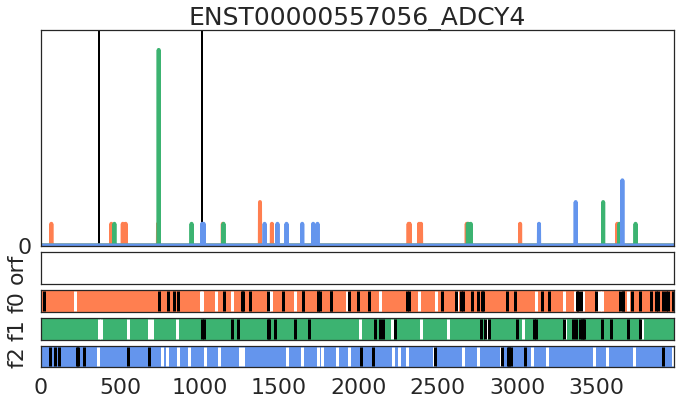

In [136]:
tr_id = 'ENST00000557056'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

FZD10 ENST00000539839
---
50
0


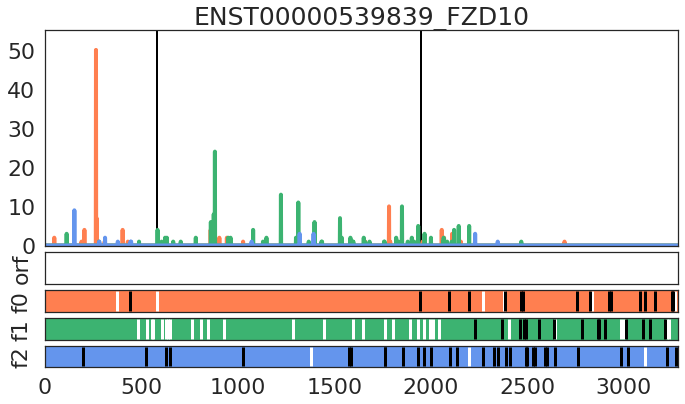

In [137]:
tr_id = 'ENST00000539839'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

SLC22A2 ENST00000366953
---
7
0


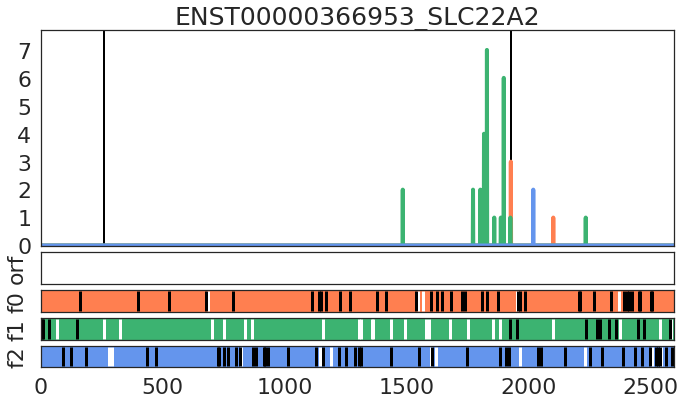

In [138]:
tr_id = 'ENST00000366953'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id) 

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =1, 
                             fraq = 500, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

C1orf87 ENST00000450089
---
3
0


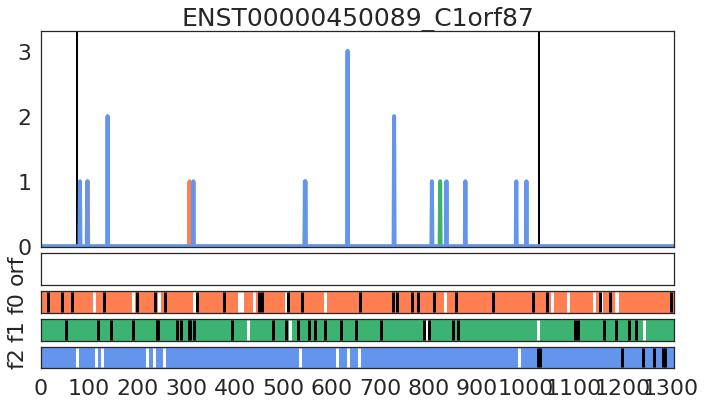

In [139]:
tr_id = 'ENST00000450089'
gene =  metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
print (gene, tr_id)

pre_st = False 
print ('---')

xlims = 'full'
d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = '../profiles/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =1, 
                             fraq = 100, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=True)

trips_full2(d1, name='a.png', font1=22, font2=25)

# Match by expression RiboSET

In [12]:
def find(A, B, dmat):

    # Initialize a place to store what columns we select so we can filter out the ones we choose
    selected = []
    
    # Initialize a place to store the output
    pairs = np.zeros((len(A), 2))
    
    for i in range(len(A)):
        if i % 100 == 0:
            print (i)
        # Sort the observations in descending order
        
        try:
            choices = dmat[i].argsort()
        
            # Eliminate those observations already selected
            remaining_choices = choices[~np.isin(choices, selected)]
        
            # Append the observation to select
            choose = remaining_choices[0]
            selected.append(choose)
        
            # Select the closest observation
            pairs[i] = [i, choose]
        except Exception as e:
            print (e)
            break
    return pairs

In [13]:
li = []

for el1 in RiboSET_CDS_cov_df[['tr_id1', 'CDS_coverage']].to_numpy():
    tr_id_r = el1[0]
    CDS_cov_r = el1[1]
    
    for el in  subset[['tr_id1', 'CDS_coverage']].to_numpy():
        tr_id = el[0]
        CDS_cov_comp = el[1]
        
        #if np.abs(CDS_cov_comp - CDS_cov_r) < 850:
        
        li.append([tr_id_r, CDS_cov_r, tr_id, CDS_cov_comp, np.abs(CDS_cov_comp - CDS_cov_r)])
            
distances = pd.DataFrame(li, columns = ['tr_id_r', 'CDS_cov_r', 'tr_id1', 'CDS_cov_comp', 'dist'])

matrix = distances.pivot(index='tr_id_r', columns='tr_id1', values='dist')
dmat = matrix.to_numpy()
A = list(matrix.index)
B = list(matrix.columns)

print (matrix.shape)

pairs = find(A, B, dmat)

B_df = pd.DataFrame({'tr_id1': B, 'ind_B': list(range(0, len(B)))})

(390, 384)
0
100
200
300
index 0 is out of bounds for axis 0 with size 0


In [14]:
pairs_ind_df = pd.DataFrame(pairs,columns = ['ind_A', 'ind_B'])

pairs_ind_df['tr_id_r'] = A

pairs_ind_df['ind_B'] = pairs_ind_df['ind_B'].astype(int)

pairs_392_final = pairs_ind_df.merge(B_df, on='ind_B', how='inner').merge(distances, on=['tr_id1', 'tr_id_r'], how='inner')

print (pairs_392_final.tr_id_r.nunique(), pairs_392_final.tr_id1.nunique())

390 384


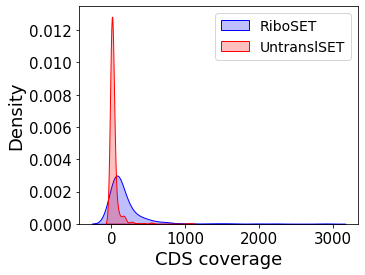

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax = sns.distplot(pairs_392_final['CDS_cov_r'].tolist(), 
                  hist=False, 
                  label = 'RiboSET',
                 kde_kws = {'shade': True, 'linewidth': 1},
                 color = 'blue')


ax = sns.distplot(pairs_392_final['CDS_cov_comp'].tolist(), 
                  hist=False, 
                  label = 'UntranslSET',
                 kde_kws = {'shade': True, 'linewidth': 1},
                 color = 'red')

ax.set_xlabel('CDS_cov_match')

stat, pvalue = stats.ks_2samp(pairs_392_final['CDS_cov_r'].tolist(), 
              pairs_392_final['CDS_cov_comp'].tolist())


#ax.text(500, 0.0015, "KS test pv=%s, stat=%s" % (np.round(pvalue, 2), np.round(stat, 2)), 
#        bbox=dict(facecolor='white', alpha=0.5), 
#        fontsize=17)

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

ax.set_ylabel('Density', fontsize= 18)
ax.set_xlabel('CDS coverage', fontsize= 18)

plt.legend(loc=0, prop={'size': 14})

plt.show()

In [16]:
tmp = pairs_392_final[['tr_id_r']]
tmp.columns = ['tr_id1']
r = tmp.merge(meta[['tr_id1', 'gene']])['gene'].tolist()

tmp = pairs_392_final[['tr_id1']]
tmp.columns = ['tr_id1']
untr = tmp.merge(meta[['tr_id1', 'gene']])['gene'].tolist()


set(r).intersection(untr)

set()

In [17]:
pairs_392_final.to_csv('pairs_390_FINAL.txt', sep='\t', index=False)

In [18]:
pairs_392_final.tr_id1.nunique()

384

In [19]:
subset.to_csv('all_subset_FINAL.txt', sep='\t', index=False)

In [20]:
subset.shape[0]

384

# Compare PCSF scores

In [21]:
a = RiboSET['PhyloCSF120score'].tolist()
a1 = meta[meta['tr_id1'].isin(RiboSET_EXT_cds_cov_nonzero['tr_id1'].unique())]['PhyloCSF120score'].tolist()

# matching set of 392 genes by CDS cov 
b = meta[meta['tr_id1'].isin(subset['tr_id1'].unique())]['PhyloCSF120score'].tolist()

len(a), len(a1), len(b)

(390, 3453, 384)

2.2398219834407485e-06


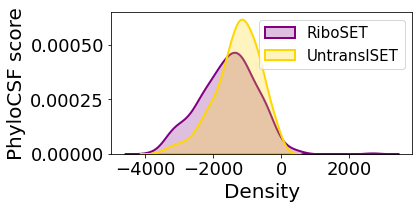

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5.4, 2.6))

ax = sns.distplot(a, 
                  hist=False, 
                  label = 'RiboSET',
                 kde_kws = {'shade': True, 'linewidth': 2},
                 color = 'purple')


ax = sns.distplot(b, 
                  hist=False, 
                  label = 'UntranslSET',
                 kde_kws = {'shade': True, 'linewidth': 2},
                 color = 'gold')

ax.set_xlabel('PhyloCSF_score_50codons')

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=18, rotation = 0)
ax.tick_params(axis='both', which='minor', labelsize=18)

ax.set_xlabel('Density', fontsize= 20)
ax.set_ylabel('PhyloCSF score', fontsize= 20)

stat, pvalue = stats.ks_2samp(a, 
              b)

print (pvalue)

#ax.text(100, 0.0005, "KS test pv=%s, stat=%s" % (np.round(pvalue, 2), np.round(stat, 2)), 
#        bbox=dict(facecolor='white', alpha=0.5), 
#        fontsize=17)

#ax.text(200, 0.0003, "KS pv=0.0032",fontsize=17)


plt.legend(loc=0, prop={'size': 15})

plt.show()

2.2398219834407485e-06


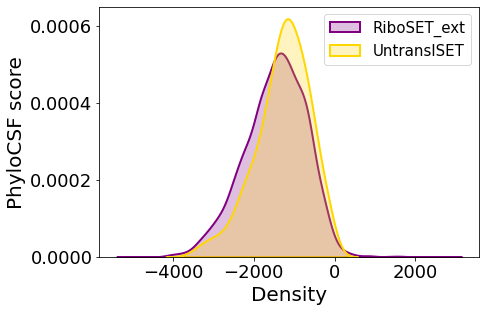

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6.8, 4.6))

ax = sns.distplot(a1, 
                  hist=False, 
                  label = 'RiboSET_ext',
                 kde_kws = {'shade': True, 'linewidth': 2},
                 color = 'purple')


ax = sns.distplot(b, 
                  hist=False, 
                  label = 'UntranslSET',
                 kde_kws = {'shade': True, 'linewidth': 2},
                 color = 'gold')

ax.set_xlabel('PhyloCSF_score_50codons')

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=18, rotation = 0)
ax.tick_params(axis='both', which='minor', labelsize=18)

ax.set_xlabel('Density', fontsize= 20)
ax.set_ylabel('PhyloCSF score', fontsize= 20)

stat, pvalue = stats.ks_2samp(a, 
              b)

print (pvalue)

#ax.text(100, 0.0005, "KS test pv=%s, stat=%s" % (np.round(pvalue, 2), np.round(stat, 2)), 
#        bbox=dict(facecolor='white', alpha=0.5), 
#        fontsize=17)

#ax.text(200, 0.0003, "KS pv=0.0032",fontsize=17)


plt.legend(loc=0, prop={'size': 15})

plt.show()

In [24]:
RiboSET_genes = RiboSET['gene'].tolist()
PhyloSET_genes = list(PhyloSET['gene'].unique())
RiboSET_ext_genes = RiboSET_EXT_cds_cov_nonzero['gene'].unique() 

print (len(RiboSET_genes), len(PhyloSET_genes), len(RiboSET_ext_genes))

# Ivanov et al sets 
# genes from 2011 paper
genes_42 = 'RASL10B,FGFR1,YPEL2,ENOX2,UFSP1,WDR26,TIAL1,YPEL4,NGF,TRPV6,KCTD11,STARD10,YPEL1,R3HCC1,ZFP62,NHLRC4,EPHX3,C1QL4,TLE3,HDGF,ANKRD42,FAM217B,NFKBID,PTEN,RNF187,METTL23,TMEM8B,VANGL2,FNDC5,C1QL1,CITED1,EIF4G3,HELZ2,CYTH2,NTF3,MFSD4B,C1QL3,KCNN4,IFT46,RASD2,CITED2,C1QL2'.split(',')
genes_17 = 'GTF3A, EIF4G2, SP3, PRPS1L1, TEAD4, TEAD3, CACNG8, OAZ3, TEAD1, DDX17, VEGFA, NR1I2, HCK, WT1, BAG1, NPW, MYC'.split(', ')

already_ann_24 = ['FNDC5', 'OAZ3', 'RNF187', 'SP3', 'NR1I2', 'TEAD3', 'VEGFA',
 'PRPS1L1', 'TRPV6', 'R3HCC1', 'MYC', 'BAG1', 'EIF4G2', 'WT1', 'TEAD4', 'GTF3A', 
                  'NPW', 'KCTD11', 'YPEL2', 'NFKBID', 'CACNG8', 'HCK', 'YPEL1', 'DDX17']

remaining_7 = ['ANKRD42', 'C1QL1', 'HELZ2', 'PTEN', 'TIAL1', 'WDR26', 'ZFP62']

not_yet_ann_28 = list(set(genes_42+genes_17) - set(already_ann_24+remaining_7))

print (len(already_ann_24), len(not_yet_ann_28))

390 60 3451
24 28


In [25]:
PCSF_24genes = pd.read_csv('../../tmp_res/PCSF_for_24_ann.txt', sep='\t')

PCSF_24genes_score = PCSF_24genes[['gene', 'PhyloCSF120score']].drop_duplicates()['PhyloCSF120score'].tolist()

PCSF_28genes_score = meta[meta['gene'].isin(not_yet_ann_28)][['gene', 'PhyloCSF120score']].drop_duplicates()['PhyloCSF120score'].tolist()

print (PCSF_24genes.gene.nunique())

24


In [26]:
PCSF_24genes[PCSF_24genes['PhyloCSF120score'] > 0]['gene'].nunique()

11

In [27]:
g = pd.DataFrame({'PCSF_score': PCSF_28genes_score})
g['subset'] = 'un_28'
e = pd.DataFrame({'PCSF_score': PCSF_24genes_score})
e['subset'] = 'ann_24'
f = pd.concat([e,g])

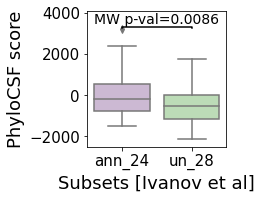

In [28]:
fig,ax = plt.subplots(figsize=(2.5,2.5))

ax = sns.boxplot(x="subset", y="PCSF_score", data=f, palette="PRGn")

# statistical annotation
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = f['PCSF_score'].max() + 30, 50, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "MW p-val=0.0086", ha='center', va='bottom', 
         color=col, fontsize= 14)

ax.set_ylim(-2500, 4100)

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=15, rotation = 0)
ax.tick_params(axis='both', which='minor', labelsize=15)

ax.set_xlabel('Subsets [Ivanov et al]', fontsize= 18)
ax.set_ylabel('PhyloCSF score', fontsize= 18)

#plt.legend(loc=0, prop={'size': 14})

plt.show()

In [29]:
would_be_in_PhyloSET_genes = PCSF_24genes[PCSF_24genes['PhyloCSF120score'] > 0]['gene'].unique()

In [30]:
PhyloSET_genes

['HES3',
 'RERE',
 'IFFO2',
 'TAF12',
 'SFPQ',
 'OAZ3',
 'VANGL2',
 'NRXN1',
 'C1QL2',
 'MAP3K19',
 'SLC6A1',
 'ZBTB47',
 'ADCY5',
 'H1FX',
 'TRPC1',
 'SLC4A4',
 'MAB21L2',
 'FBXW7',
 'HNRNPA0',
 'MARCKS',
 'MAP3K5',
 'POMZP3',
 'SLC35G5',
 'ENY2',
 'C1QL3',
 'NAV2',
 'ALDH3B2',
 'GLTP',
 'MAB21L1',
 'PELI2',
 'PLEKHG3',
 'FEM1B',
 'SULT1A1',
 'AC007906.1',
 'MAF',
 'GLOD4',
 'FXR2',
 'TNFAIP1',
 'TBC1D29',
 'HOXB5',
 'RPTOR',
 'MIB1',
 'SMAD7',
 'CCDC8',
 'CYTH2',
 'CACNG8',
 'ACTL10',
 'GDF5OS',
 'RIMS4',
 'HELZ2',
 'RANBP1',
 'LRP5L',
 'SOX10',
 'KIAA0930',
 'WWC3',
 'USP27X',
 'DLG3',
 'PABPC1L2B',
 'PABPC1L2A',
 'UBE2A']

In [31]:
not_yet_ann_28

['EIF4G3',
 'TEAD1',
 'C1QL2',
 'STARD10',
 'UFSP1',
 'RASL10B',
 'IFT46',
 'HDGF',
 'FGFR1',
 'CYTH2',
 'TMEM8B',
 'YPEL4',
 'C1QL4',
 'NTF3',
 'METTL23',
 'CITED1',
 'CITED2',
 'EPHX3',
 'NGF',
 'ENOX2',
 'VANGL2',
 'MFSD4B',
 'NHLRC4',
 'KCNN4',
 'RASD2',
 'C1QL3',
 'FAM217B',
 'TLE3']

In [32]:
len(PhyloSET_genes), len(RiboSET_genes), len(not_yet_ann_28)

(60, 390, 28)

In [33]:
set(PhyloSET_genes).intersection(set(not_yet_ann_28))

{'C1QL2', 'C1QL3', 'CYTH2', 'VANGL2'}

In [34]:
set(RiboSET_genes).intersection(set(not_yet_ann_28))

{'CYTH2', 'HDGF'}

In [36]:
metadata_pc_g25['gene'].unique()

array(['OR4F5', 'FO538757.2', 'FO538757.1', ..., 'MT-ND5', 'MT-ND6',
       'MT-CYB'], dtype=object)

In [37]:
len(RiboSET_ext_genes), len(RiboSET_genes), len(PhyloSET_genes)

(3451, 390, 60)

In [38]:
localisation_df = pd.read_csv('../../data/subcellular_location.tsv', sep='\t')

print (localisation_df['Gene name'].nunique())
print (localisation_df[localisation_df['Reliability'].isin(['Supported', 'Approved', 'Enhanced'])]['Gene name'].nunique())
print (localisation_df['Reliability'].unique())

# filter out uncertain location 
sel_loc = localisation_df[localisation_df['Reliability'].isin(['Supported', 'Approved', 'Enhanced'])][['Gene name',
                                                                                                      'Main location',
                                                                                                      'Additional location', 'Extracellular location']]

sel_loc.columns = ['gene', 'Main location', 'Additional location', 'Extracellular location']

sel_loc['locations'] = sel_loc['Main location'].astype(str)+';'+sel_loc['Additional location'].astype(str)+';'+sel_loc['Extracellular location'].astype(str)
sel_loc['locations'] = sel_loc['locations'].str.replace('nan;', '').str.replace('nan', '').str.rstrip(';')

sel_loc[0:2]

12804
12086
['Approved' 'Uncertain' 'Supported' 'Enhanced']


,gene,Main location,Additional location,Extracellular location,locations
0,TSPAN6,Cell Junctions;Cytosol,Nucleoli fibrillar center,NaN,Cell Junctions;Cytosol;Nucleoli fibrillar center
2,C1orf112,Mitochondria,NaN,NaN,Mitochondria


# PhyloSET to HPA

In [39]:
PhyloSET_loc = PhyloSET.merge(sel_loc, on='gene', how='inner')
print (PhyloSET_loc.shape[0])

nucleoplasm_count = 0
cytosol_count = 0
Mitochondria_count = 0
membrane_count = 0


two_more_loc = 0

all_locations = set()
two_more_loc_ = set()

for i,x in enumerate(PhyloSET_loc[['gene', 'locations']].drop_duplicates()['locations'].tolist()):
   
    #print (x)
    for loc in x.split(';'):
        all_locations.add(loc)
    
    if x == 'Nucleoplasm':
        nucleoplasm_count += 1
    if x == 'Cytosol':
        cytosol_count += 1
    if x == 'Mitochondria':
        Mitochondria_count += 1
    if x == 'Plasma membrane':
        membrane_count += 1

    if len(x.split(';')) >= 2:
        #if x in truly_2diff_loc:
        two_more_loc += 1
        two_more_loc_.add(x)
        


n = PhyloSET_loc[['gene', 'locations']].drop_duplicates().shape[0]
nucleoplasm_count/n*100, cytosol_count/n*100, Mitochondria_count/n*100, membrane_count/n*100, two_more_loc/n*100

59


(27.500000000000004, 12.5, 0.0, 2.5, 50.0)

In [40]:
two_more_loc, n-two_more_loc

(20, 20)

In [41]:
perc_PhyloSET = pd.DataFrame([50, 50], 
                   index=['>=2', '1'])
                       
perc_PhyloSET.columns = ['PhyloSET']

perc_PhyloSET

,PhyloSET
>=2,50
1,50


# RiboSET and HPA

In [42]:
RiboSET_loc = RiboSET.merge(sel_loc, on='gene', how='inner')
print (RiboSET_loc.shape[0])

nucleoplasm_count = 0
cytosol_count = 0
Mitochondria_count = 0
membrane_count = 0

two_more_loc = 0
two_more_loc_ = set()

all_locations = set()

for i,x in enumerate(RiboSET_loc['locations'].tolist()):
    
    for loc in x.split(';'):
        all_locations.add(loc)
    
    if x == 'Nucleoplasm':
        nucleoplasm_count += 1
    if x == 'Cytosol':
        cytosol_count += 1
    if x == 'Mitochondria':
        Mitochondria_count += 1
    if x == 'Plasma membrane':
        membrane_count += 1
        
    if len(x.split(';')) >= 2:
        two_more_loc += 1
        two_more_loc_.add(x)
        #if x in truly_2diff_loc:
            #two_more_loc += 1

n = RiboSET_loc.shape[0]
nucleoplasm_count/n*100, cytosol_count/n*100, Mitochondria_count/n*100, membrane_count/n*100, two_more_loc/n*100

317


(14.195583596214512,
 12.302839116719243,
 4.100946372239748,
 1.8927444794952681,
 52.6813880126183)

In [43]:
two_more_loc, n-two_more_loc

(167, 150)

In [44]:
perc_RiboSET = pd.DataFrame([52.68, 100-52.68], 
                   index=['>=2', '1'])
                       
perc_RiboSET.columns = ['RiboSET']

perc_RiboSET

,RiboSET
>=2,52.68
1,47.32


# Match 384 loc

In [45]:
Match_392_loc = subset[['tr_id1']].merge(meta[['tr_id1', 'gene']], on='tr_id1', how='inner').merge(sel_loc, on='gene', how='inner')

nucleoplasm_count = 0
cytosol_count = 0
Mitochondria_count = 0
membrane_count = 0

two_more_loc = 0

all_locations = set()

for i,x in enumerate(Match_392_loc['locations'].tolist()):
    
    for loc in x.split(';'):
        all_locations.add(loc)
    
    if x == 'Nucleoplasm':
        nucleoplasm_count += 1
    if x == 'Cytosol':
        cytosol_count += 1
    if x == 'Mitochondria':
        Mitochondria_count += 1
    if x == 'Plasma membrane':
        membrane_count += 1
        
    if len(x.split(';')) >= 2:
        two_more_loc += 1
        #if x in truly_2diff_loc:
            #two_more_loc += 1
        
n = Match_392_loc['locations'].shape[0]
nucleoplasm_count/n*100, cytosol_count/n*100, Mitochondria_count/n*100, membrane_count/n*100, two_more_loc/n*100

(9.615384615384617,
 8.461538461538462,
 1.5384615384615385,
 2.6923076923076925,
 63.07692307692307)

In [46]:
two_more_loc, n-two_more_loc

(164, 96)

In [47]:
perc_match = pd.DataFrame([63.07, 100-63.07], 
                   index=['>=2', '1'])
                       
perc_match.columns = ['UntranslSET']

perc_match

,UntranslSET
>=2,63.07
1,36.93


In [48]:
tmp = pd.concat([perc_match, perc_RiboSET, perc_PhyloSET], axis=1).reset_index()

tmp2 = pd.melt(tmp, id_vars='index', value_vars=['UntranslSET', 'RiboSET', 'PhyloSET'])

tmp2.columns = ['#locations in HPA', 'subset', 'fraction']

tmp2

,#locations in HPA,subset,fraction
0,>=2,UntranslSET,63.07
1,1,UntranslSET,36.93
2,>=2,RiboSET,52.68
3,1,RiboSET,47.32
4,>=2,PhyloSET,50.00
5,1,PhyloSET,50.00


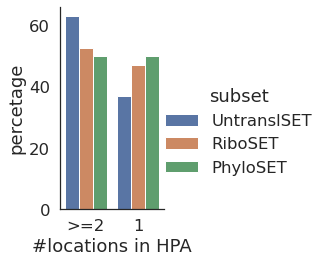

In [49]:
#fig,ax = plt.subplots(figsize=(5,5))

sns.set(font_scale = 1.5)
sns.set_style("white")

g = sns.catplot(x = "#locations in HPA",       # x variable name
            y = "fraction",       # y variable name
            hue = "subset",  # group variable name
            data = tmp2,     # dataframe to plot
            kind = "bar",
               aspect=0.8,
               height=4)

# We change the fontsize of minor ticks label 
#ax.tick_params(axis='both', which='major', labelsize=15, rotation = 0)
#ax.tick_params(axis='both', which='minor', labelsize=15)


g.set_axis_labels(x_var="#locations in HPA", y_var="percetage", fontsize=18)

In [50]:
# RiboSET vs matched no translation 

a = 167 # 2 locations 
b = 150
c = 164
d = 96 # 2 locations 

# 184, 126


table  = [[a, b],  [c, d]] 

oddsr, p = fisher_exact(table, alternative='greater')

p, oddsr

(0.9953620867607589, 0.6517073170731708)

In [51]:
# PhyloSET vs matched no translation 

a = 20 # 2 locations 
b = 20
c = 164
d = 96 # 2 locations 

# 184, 126


table  = [[a, b],  [c, d]] 

oddsr, p = fisher_exact(table, alternative='greater')

p, oddsr

(0.9592142087739679, 0.5853658536585366)

# RiboSET_ext

In [61]:
RiboSET_ext_loc.to_csv('../Supplementary_tables/RiboSET_ext_loc_HPA.txt', sep='\t', index=False)

In [52]:
RiboSET_ext_loc = RiboSET_EXT_cds_cov_nonzero[['gene']].merge(sel_loc, on='gene', how='inner')
print (RiboSET_ext_loc.shape[0])

nucleoplasm_count = 0
cytosol_count = 0
Mitochondria_count = 0
membrane_count = 0

two_more_loc = 0
two_more_loc_ = set()

all_locations = set()

for i,x in enumerate(RiboSET_ext_loc['locations'].tolist()):
    
    for loc in x.split(';'):
        all_locations.add(loc)
    
    if x == 'Nucleoplasm':
        nucleoplasm_count += 1
    if x == 'Cytosol':
        cytosol_count += 1
    if x == 'Mitochondria':
        Mitochondria_count += 1
    if x == 'Plasma membrane':
        membrane_count += 1
        
    if len(x.split(';')) >= 2:
        two_more_loc += 1
        two_more_loc_.add(x)
        #if x in truly_2diff_loc:
            #two_more_loc += 1

n = RiboSET_ext_loc.shape[0]
nucleoplasm_count/n*100, cytosol_count/n*100, Mitochondria_count/n*100, membrane_count/n*100, two_more_loc/n*100

2461


(13.856156034132466,
 7.882974400650141,
 3.657049979683056,
 2.356765542462414,
 58.39089800893945)

In [53]:
RiboSET_ext_loc_df = pd.DataFrame([58.39, 100-58.39], 
                   index=['>=2', '1'])
                       
RiboSET_ext_loc_df.columns = ['RiboSET_ext']

RiboSET_ext_loc_df

,RiboSET_ext
>=2,58.39
1,41.61


In [54]:
two_more_loc, n- two_more_loc

(1437, 1024)

In [55]:
perc_match = pd.DataFrame([63.07, 100-63.07], 
                   index=['>=2', '1'])
                       
perc_match.columns = ['UntranslSET']

perc_match

,UntranslSET
>=2,63.07
1,36.93


In [58]:
RiboSET_ext_loc_df

,RiboSET_ext
>=2,58.39
1,41.61


In [56]:
tmp = pd.concat([perc_match, RiboSET_ext_loc_df], axis=1).reset_index()

tmp2 = pd.melt(tmp, id_vars='index', value_vars=['UntranslSET', 'RiboSET_ext'])

tmp2.columns = ['# locations in HPA', 'subset', 'fraction']

tmp2

,# locations in HPA,subset,fraction
0,>=2,UntranslSET,63.07
1,1,UntranslSET,36.93
2,>=2,RiboSET_ext,58.39
3,1,RiboSET_ext,41.61


/home/alla/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3750: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


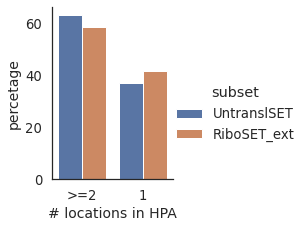

In [57]:
#fig,ax = plt.subplots(figsize=(5,5))

sns.set(font_scale = 1.2)
sns.set_style("white")

g = sns.catplot(x = "# locations in HPA",       # x variable name
            y = "fraction",       # y variable name
            hue = "subset",  # group variable name
            data = tmp2,     # dataframe to plot
            kind = "bar",
               size=3.4, aspect=0.9)

# We change the fontsize of minor ticks label 
#ax.tick_params(axis='both', which='major', labelsize=15, rotation = 0)
#ax.tick_params(axis='both', which='minor', labelsize=15)


g.set_axis_labels(x_var="# locations in HPA", y_var="percetage", fontsize=14)

In [197]:
# PhyloSET vs matched no translation 

a = 1437  # 2 locations 
b = 1024
c = 164
d = 96 # 2 locations 

# 184, 126


table  = [[a, b],  [c, d]] 

oddsr, p = fisher_exact(table, alternative='greater')

p, oddsr

(0.9371485562288507, 0.8214557926829268)

In [198]:
1024+1437

2461